# Finland Electricity Price Forecasting

### Workflow:
1. **Data Prep:** Load and split data.
2. **Baselines:** Establish the floor performance with naive models.
3. **Experimentation:** Tune 3 distinct architectures (XGBoost, LightGBM, SVR).
4. **Final Training:** Train the final production model.
5. **Visualization:** Analyze errors, visualize predictions, and assess feature importance.
6. **Saving:** Save model and features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
import mlflow
import optuna
import joblib
import pickle
import warnings
import logging
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from optuna.integration import XGBoostPruningCallback, LightGBMPruningCallback

# Configuration 
DATA_PATH = "../data/processed_feature_data.csv"
VAL_START = '2025-06-01'
TEST_START = '2025-09-01'
TARGET = 'price'
N_TRIALS = 20
RANDOM_STATE = 42

# Setup 
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger("mlflow").setLevel(logging.ERROR)

mlflow.set_tracking_uri("sqlite:///../mlflow.db")
mlflow.set_experiment("Electricity_price_prediction")

2025/12/17 12:53:07 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/17 12:53:07 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/17 12:53:07 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/17 12:53:07 INFO alembic.runtime.migration: Will assume non-transactional DDL.


<Experiment: artifact_location='file:c:/programming/electricity_predictor/notebooks/mlruns/6', creation_time=1765968787491, experiment_id='6', last_update_time=1765968787491, lifecycle_stage='active', name='Electricity_price_prediction', tags={}>

## 1. Data Loading & Splitting

In [2]:
def load_and_split(path):
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index, utc=True)
    df = df.tz_convert('Europe/Helsinki')
    df = df.astype(np.float64)
    
    features = [c for c in df.columns if c != TARGET]
    
    # Time Series Split 
    X_train = df.loc[df.index < VAL_START, features]
    y_train = df.loc[df.index < VAL_START, TARGET]
    
    X_val = df.loc[(df.index >= VAL_START) & (df.index < TEST_START), features]
    y_val = df.loc[(df.index >= VAL_START) & (df.index < TEST_START), TARGET]
    
    X_test = df.loc[df.index >= TEST_START, features]
    y_test = df.loc[df.index >= TEST_START, TARGET]
    
    X_train_full = pd.concat([X_train, X_val])
    y_train_full = pd.concat([y_train, y_val])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_train_full, y_train_full, features

X_train, y_train, X_val, y_val, X_test, y_test, X_train_full, y_train_full, feature_names = load_and_split(DATA_PATH)

print(f"Data Loaded. Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Data Loaded. Train: 20948 | Val: 2205 | Test: 2187


## 2. Baselines

In [3]:
# 1. Global Mean
mean_pred = np.full(shape=y_test.shape, fill_value=y_train.mean())
mae_mean = mean_absolute_error(y_test, mean_pred)

# 2. Persistence (Lag 24)
persistence_pred = X_test['price_lag_24']
mae_persist = mean_absolute_error(y_test, persistence_pred)

# 3. Linear Model (Ridge)
ridge_pipe = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
ridge_pipe.fit(X_train_full, y_train_full)
ridge_pred = ridge_pipe.predict(X_test)
mae_ridge = mean_absolute_error(y_test, ridge_pred)

print(f"1. Global Mean MAE:   {mae_mean:.2f} €")
print(f"2. Persistence MAE:   {mae_persist:.2f} €")
print(f"3. Linear Ridge MAE:  {mae_ridge:.2f} €")

1. Global Mean MAE:   42.43 €
2. Persistence MAE:   39.02 €
3. Linear Ridge MAE:  25.04 €


## 3. Candidate Model Exploration (Optuna)
Tuning three architectures to see which handles the data best.
1. **XGBoost:** The standard for tabular data.
2. **LightGBM:** Faster, leaf-wise growth.
3. **SVR (RBF Kernel):** Captures smooth non-linearities better than trees.


In [4]:
# --- 1. XGBoost Tuning ---
print(f"\nTuning XGBoost ({N_TRIALS} trials)")

def objective_xgb(trial):
    params = {
        'n_estimators': 3000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'objective': 'reg:absoluteerror',
        'n_jobs': -1,
        'random_state': RANDOM_STATE
    }
    
    # Pruning callback for speed
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-mae")
    
    model = xgb.XGBRegressor(**params, callbacks=[pruning_callback], early_stopping_rounds=50)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    return mean_absolute_error(y_val, model.predict(X_val))

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=N_TRIALS)
best_params_xgb = study_xgb.best_params
best_params_xgb.update({'n_estimators': 3000, 'objective': 'reg:absoluteerror', 'n_jobs': -1, 'random_state': RANDOM_STATE})
print(f"Best XGB MAE (Val): {study_xgb.best_value:.2f}")


# --- B. LightGBM Tuning ---
print(f"\nTuning LightGBM ({N_TRIALS} trials)")

def objective_lgb(trial):
    params = {
        'n_estimators': 3000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'regression_l1', # MAE
        'verbosity': -1,
        'n_jobs': -1,
        'random_state': RANDOM_STATE
    }
    
    model = lgb.LGBMRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mae',
        callbacks=[
            LightGBMPruningCallback(trial, "l1"),
            lgb.early_stopping(stopping_rounds=50, verbose=False)
        ]
    )
    return mean_absolute_error(y_val, model.predict(X_val))

study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=N_TRIALS)
best_params_lgb = study_lgb.best_params
best_params_lgb.update({'n_estimators': 3000, 'objective': 'regression_l1', 'verbosity': -1, 'n_jobs': -1, 'random_state': RANDOM_STATE})
print(f"Best LGBM MAE (Val): {study_lgb.best_value:.2f}")


# --- C. SVR Tuning ---
print(f"\nTuning SVR ({N_TRIALS} trials)")

def objective_svr(trial):
    # Subsample for faster tuning (last 10000 hours of training)
    X_sub = X_train.iloc[-10000:]
    y_sub = y_train.iloc[-10000:]
    
    params = {
        'C': trial.suggest_float('C', 0.1, 100, log=True),
        'epsilon': trial.suggest_float('epsilon', 0.01, 1.0, log=True),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'kernel': 'rbf'
    }
    
    # Pipeline for SVR to scale correctly
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svr', SVR(**params))
    ])
    
    model.fit(X_sub, y_sub)
    return mean_absolute_error(y_val, model.predict(X_val))

study_svr = optuna.create_study(direction='minimize')
study_svr.optimize(objective_svr, n_trials=N_TRIALS)
best_params_svr = study_svr.best_params
print(f"Best SVR MAE (Val): {study_svr.best_value:.2f}")


Tuning XGBoost (20 trials)
Best XGB MAE (Val): 18.79

Tuning LightGBM (20 trials)
Best LGBM MAE (Val): 18.52

Tuning SVR (20 trials)
Best SVR MAE (Val): 19.00


## 4. Final Training & Ensemble
Re-training the models on the Full Training Set (Train + Validation) using the best parameters found. 
Using `mlflow.autolog()` to capture the final artifact details.

In [10]:
# Enable autologging 
mlflow.sklearn.autolog()
mlflow.xgboost.autolog()
mlflow.lightgbm.autolog()

with mlflow.start_run(nested=True, run_name="Final training") as parent_run:
    
    pred_xgb, pred_lgb, pred_svr = None, None, None

    # 1. Train XGBoost 
    with mlflow.start_run(nested=True, run_name="XGBoost Model"):
        print("Training final XGBoost...")
        final_xgb = xgb.XGBRegressor(**best_params_xgb)
        final_xgb.fit(X_train_full, y_train_full, eval_set=[(X_test, y_test)], verbose=False)
        pred_xgb = final_xgb.predict(X_test)
        mae_xgb = mean_absolute_error(y_test, pred_xgb)
        mlflow.log_metric("test_mae", mae_xgb) 
        print(f"XGBoost MAE: {mae_xgb:.2f}")
        
    # 2. Train LightGBM 
    with mlflow.start_run(nested=True, run_name="LightGBM Model"):
        print("Training final LightGBM...")
        final_lgb = lgb.LGBMRegressor(**best_params_lgb)
        final_lgb.fit(X_train_full, y_train_full, eval_set=[(X_test, y_test)], eval_metric='mae', callbacks=[lgb.log_evaluation(period=0)])
        pred_lgb = final_lgb.predict(X_test)
        mae_lgb = mean_absolute_error(y_test, pred_lgb)
        mlflow.log_metric("test_mae", mae_lgb) 
        print(f"LightGBM MAE: {mae_lgb:.2f}")

    # 3. Train SVR
    with mlflow.start_run(nested=True, run_name="SVR Pipeline Model"):
        print("Training final SVR...")
        final_svr = Pipeline([
            ('scaler', StandardScaler()),
            ('svr', SVR(**best_params_svr))
        ])
        final_svr.fit(X_train_full, y_train_full)
        pred_svr = final_svr.predict(X_test)
        mae_svr = mean_absolute_error(y_test, pred_svr)
        mlflow.log_metric("test_mae", mae_svr)
        print(f"SVR MAE: {mae_svr:.2f}")


    # 4. Create Ensemble (Simple Average)
    # Check correlations between predictions
    preds_df = pd.DataFrame({'xgb': pred_xgb, 'lgb': pred_lgb, 'svr': pred_svr})
    print("\nPrediction Correlations:\n", preds_df.corr())
    
    # Average predictions
    pred_ensemble = (pred_xgb + pred_lgb + pred_svr) / 3
    mae_ensemble = mean_absolute_error(y_test, pred_ensemble)
    print(f"Ensemble MAE: {mae_ensemble:.2f}")
    
    # Log custom metrics to MLflow (in the Parent Run)
    mlflow.log_metric("test_mae_xgb", mae_xgb)
    mlflow.log_metric("test_mae_lgb", mae_lgb)
    mlflow.log_metric("test_mae_svr", mae_svr)
    mlflow.log_metric("test_mae_ensemble", mae_ensemble)

Training final XGBoost...
XGBoost MAE: 20.04
Training final LightGBM...
LightGBM MAE: 19.92
Training final SVR...
SVR MAE: 19.23

Prediction Correlations:
           xgb       lgb       svr
xgb  1.000000  0.989587  0.973192
lgb  0.989587  1.000000  0.965652
svr  0.973192  0.965652  1.000000
Ensemble MAE: 19.24


## 5. Visualizations
Interpreting the results using the XGBoost model.

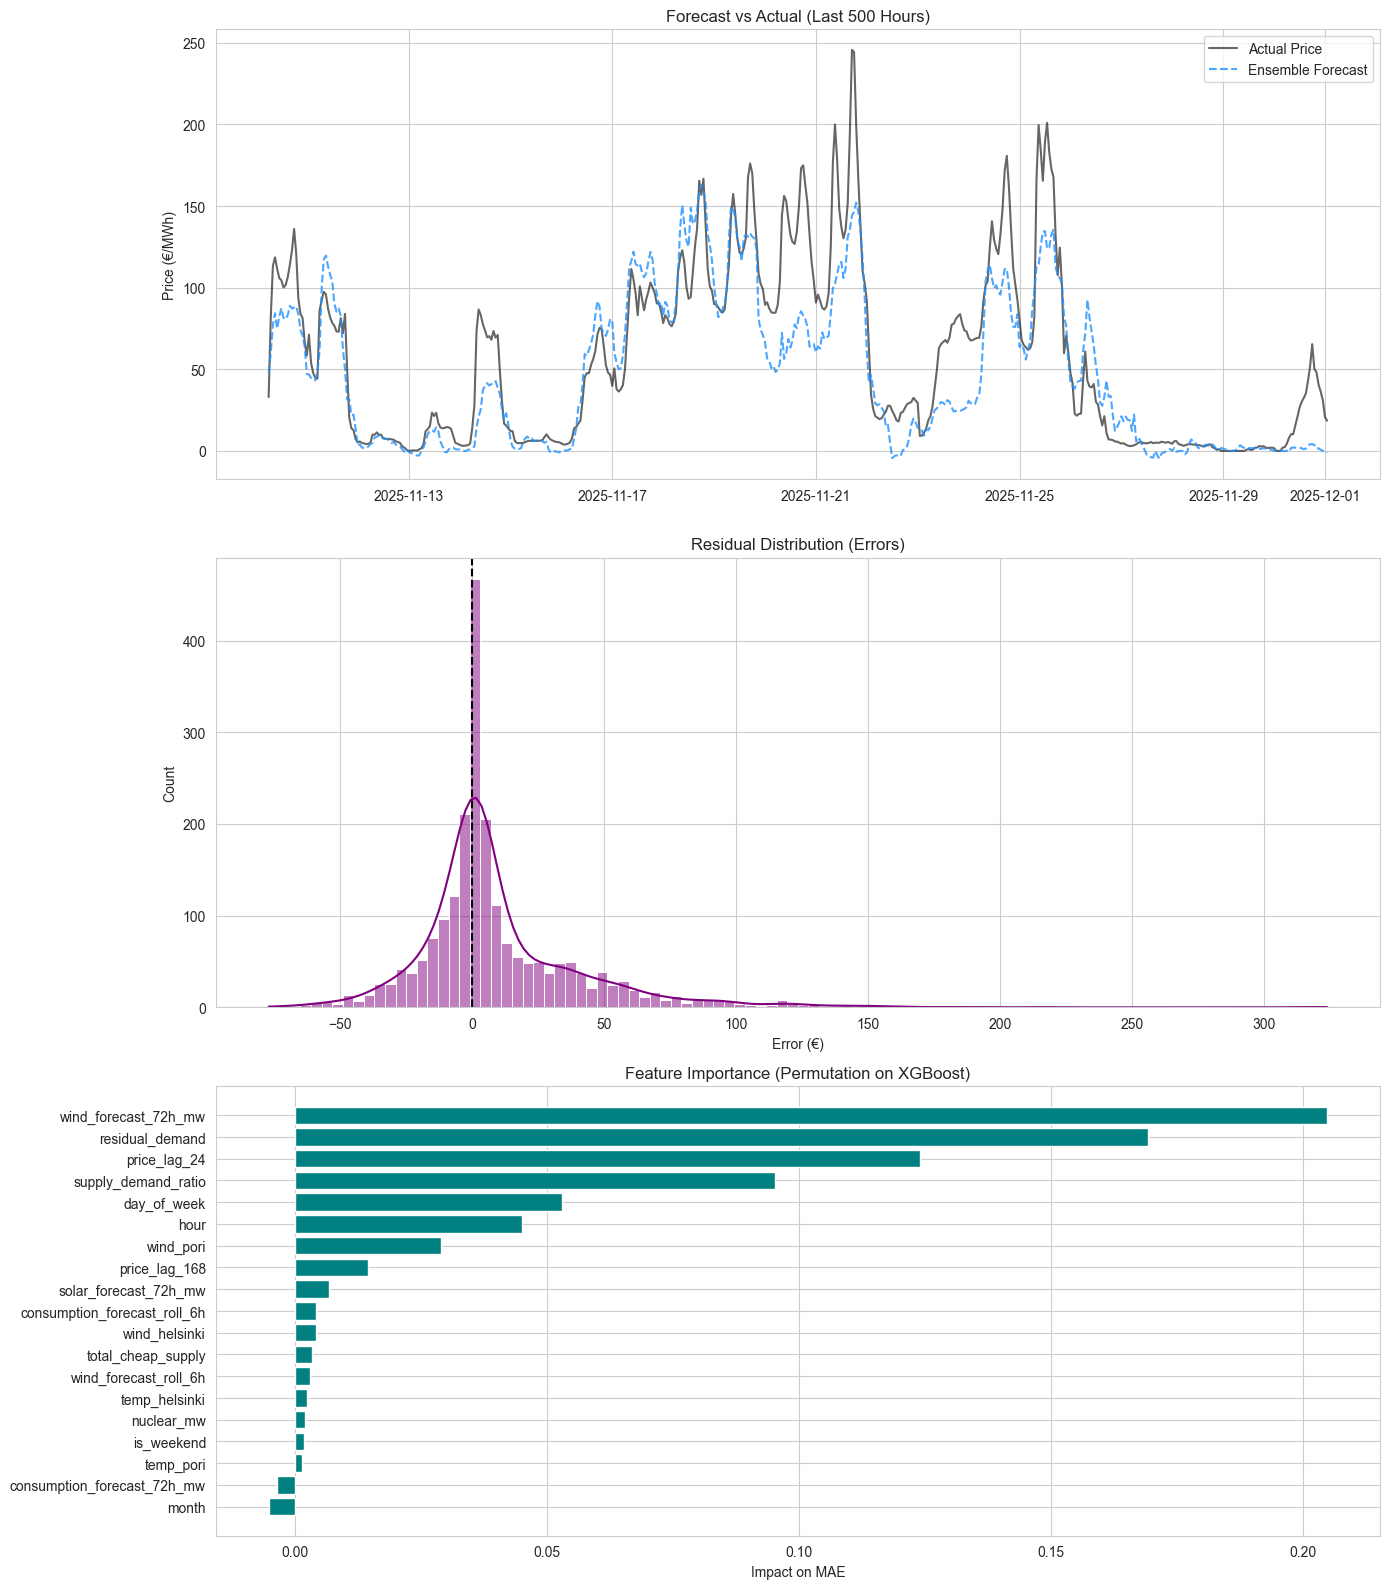

In [6]:
# Dataframe for plotting
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': pred_xgb
}, index=y_test.index).sort_index()

# Calculate residuals
results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

fig, ax = plt.subplots(3, 1, figsize=(14, 16))

# 1. Time Series Plot (last 3 weeks)
subset = results_df.iloc[-500:]
ax[0].plot(subset.index, subset['Actual'], color='black', alpha=0.6, label='Actual Price')
ax[0].plot(subset.index, subset['Predicted'], color='dodgerblue', alpha=0.8, linestyle='--', label='Ensemble Forecast')
ax[0].set_title("Forecast vs Actual (Last 500 Hours)")
ax[0].set_ylabel("Price (€/MWh)")
ax[0].legend()

# 2. Residual Histogram
sns.histplot(results_df['Residual'], bins=100, kde=True, ax=ax[1], color='purple')
ax[1].axvline(0, color='black', linestyle='--')
ax[1].set_title("Residual Distribution (Errors)")
ax[1].set_xlabel("Error (€)")

# 3. Feature Importance 
perm_imp = permutation_importance(final_xgb, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1)
sorted_idx = perm_imp.importances_mean.argsort()

ax[2].barh(X_test.columns[sorted_idx], perm_imp.importances_mean[sorted_idx], color='teal')
ax[2].set_title("Feature Importance (Permutation on XGBoost)")
ax[2].set_xlabel("Impact on MAE")

plt.tight_layout()
plt.show()

## 6. Saving model

In [7]:
# Feature List
with open("model_features.pkl", "wb") as f:
    pickle.dump(feature_names, f)

# XGBoost
final_xgb.save_model("model_xgb.json")

print("Saved model_features.pkl")
print("Saved model_xgb.json")

Saved model_features.pkl
Saved model_xgb.json
